In [1]:
%matplotlib inline
import glob
import matplotlib
import matplotlib.pylab as plt
plt.style.use('ggplot')
matplotlib.rc('image', origin='lower', cmap='magma')
matplotlib.rc('axes', grid=False)
import numpy as np
import astropy.io.fits as fits
import IPython.html.widgets as widgets
import pandas as pd
from os.path import basename
from astropy.nddata.utils import Cutout2D

/Users/jdl/miniconda2/envs/work/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<h1 style="text-align: center; margin-top: 6em;">Application of multiple dimensionality-reduction techniques to PSF estimation in high-constrast imaging</h1>

<div style="text-align: center; font-style: italic; margin-top: 4em; margin-bottom: 4em;">Ryan Boyden, Joseph Long, Samuel Wyatt, Minghao Yue</div>

## If you're following along:

1. Clone this project from GitHub to your computer: `git clone https://github.com/ryanboyden94/Ast-502-final-project.git`
2. Enter the `Ast-502-final-project/pyklip` directory and run `python setup.py develop`
3. Go back to the main project directory (`cd ..`) and open up the notebook with Jupyter (`jupyter notebook`)
4. *(optional)* Get [SWarp](https://www.astromatic.net/software/swarp) installed

## Recall: how hard is it to find your dream car?

![](https://buyersguide.caranddriver.com/media/assets/submodel/8057.jpg)

## In terms of a probablility...

The only criteria for your dream car is that it is a **Lamborghini**. For this thought experiment, assume that 10 % of the cars on the market are Lamborghinis. 

The Probability of finding your dream car is: 

$$ P(car = dream) = P(lambo) = 0.1 $$ 

Now imagine that you're picky and want a **2017 yellow Lamborghini with a spoiler and tinted windows**. 

If we assume that the probability of each specified parameter (i.e. dimension)  is 10 %, then the chances of finding your dream car is: 

$$ P(car = dream) = P(lambo) * P(2017) * P(yellow) 
                         * P(spoiler) * P(tint) = \bf{10^{-5}} $$

--> **_The curse of dimensionality_**

### Recall the "unit sample volume"...

![http://www.newsnshit.com/curse-of-dimensionality-interactive-demo/](http://i1.wp.com/www.newsnshit.com/wp-content/uploads/2014/10/580f1__Curse-of-dimensionality-620x549.png?resize=620%2C549)

The probability lowers with increasing dimension

(Richards 2016)

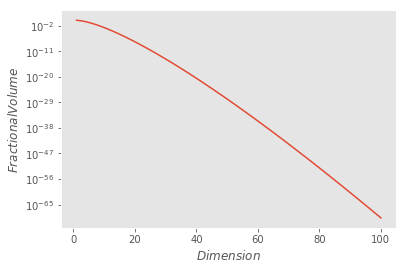

In [2]:
#curse of dimensionality
## in the limit of many dimensions, the chances of identifying 
## a data point within a unit sample volume will be zero!

%matplotlib inline
import numpy as np
import scipy.special as sp
from matplotlib import pyplot as plt

def fractionVol(dimension):
    return (np.pi**(dimension/2.))/(dimension*2.**(dimension-1.)*sp.gamma(dimension/2.))

dim = np.linspace(1,100)

#------------------------------------------------------------
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dim,fractionVol(dim))

ax.set_yscale('log')
ax.set_xlabel('$Dimension$')
ax.set_ylabel('$Fractional Volume$')

plt.show()

## Principal Component Analysis (PCA) 
- A dimensionality reduction technique that uses an orthogonal transformation to convert a set of observations of possibly **correlated** variables into a set of values of **linearly uncorrelated** variables called **principal components**. 
- Principal components are ordered by the variance captured by each new variable 


## Intuition
![](http://www.astroml.org/_images/fig_PCA_rotation_1.png)
(Lvezic Figure 7.2)
- Picture a bivariate Gaussian that is not aligned with the axes it is initially defined on. Here $x$ and $y$ are a set of correlated variables, in this case, axes. PCA identifies a new set of (orthogonal) axes that are uncorrelated, shown as $x^{\prime}$ and $y^{\prime}$.
- The principal components are orthogonal and aligned along the directions of **maximal variance with zero covariance**
    


![](http://www.astroml.org/_images/fig_PCA_rotation_1.png)

For the plot above..
  - first component $\Longleftrightarrow$ maximal variance
  - second component $\Longleftrightarrow$ maximal residual variance
Where does dimensionality reduction comes into play? 
  - The physically significant information about our data could only be along the $x^{\prime}$ axis, and the $y^{\prime}$ axis, if it's variance is small, could just be noise. Thus, we could toss the information from this second component, obtain cleaner data, and reduce the dimensionality of our problem.
  - Each principal component might correspond to a different physical effect (i.e. a star and a planet), so we could isolate, linearly, different physical effects on our data.

  
  
  

## (A review of) the formal PCA derivation

Consider a data set $\{x_i\}$ which consists of $N$ objects for which we measure $K$ features (for the bivariate Gaussian, we measured $x$ and $y$).  '

The covariance of the centered data matrix $X$ is 
$$C_X=\frac{1}{N-1}X^TX$$


PCA wishes to identify a projection of $X$, with projection operator $R$, that is aligned with the directions of maximal variance. We express this projection as $Y= X R$ with covariance 

$$ C_{Y} = \frac{1}{N-1}Y^T Y= \frac{1}{N-1} R^T X^T X R = R^T C_X R$$


$r_1$ is the first principal component of $R$, subject to the normalization constraint: $r_1^T r_1 = 1$. When the data $X$ is projected onto $r_1$, the variance is maximized. 

Formally, we can derive $r_1$ by using Langrange multipliers with the following cost function:

$$ \phi(r_1,\lambda_1) = C_Y - \lambda_1(r_1^Tr_1-1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1). $$

We maximize $\phi(r_1,\lambda)$ by taking the derivative with respect to $r_1$ and set it to 0. We then have

$$ C_Xr_1 - \lambda_1 r_1 = 0. $$

This resembles an eigenvalue equation: $ C_Xr_1 = \lambda_1 r_1$. 

The second and further principal compents are derived in an analogous manner, with the additional orthogonality constraint to the cost function (e.g . $r_i^T r_j = 0$).

Thus, the eigenvectors of $C_X$ correspond to the projections of maximum variance, where the eigenvalues denote the magnitude of the variance along each component.

# Applications of PCA to astronomy

  - We have already seen how to decompose quasar spectra with a controlled loss of information
    - Generalize the function of (x, y) above to a 1D vector (x_1, x_2, ..., x_n) with fluxes in each wavelength bin.
  - The world of high-contrast exoplanet imaging *loves* PCA

There's only one problem:

**They call it Karhunen-Loève Image Projection!** (Or KLIP, for short.)

# High-contrast imaging

We look for planets around stars other than the sun. Unfortunately, the starlight outshines thermal planet emission (think Earth's IR glow around 14ºC -- 10 microns) and reflected light (think the "pale blue dot") by many orders of magnitude.

<table>
  <tr><th>Observatory</th>   <th>Instrument</th>           <th>Contrast ratio</th><th>Contrast (magnitudes)</th></tr>
  <tr><td>ESO VLT</td>       <td>SHPERE</td>               <td>&approx; 10<sup>5</sup></td><td>12.5</td></tr>
  <tr><td>Gemini South</td>  <td>Gemini Planet Imager</td> <td>&approx; 10<sup>6</sup></td><td>15</td></tr>
  <tr><td>Magellan Clay</td> <td>Clio + vAPP</td>          <td>&approx; 10<sup>5</sup> &ndash; 10<sup>6</sup></td><td>12.5 - 15</td></tr>
</table>

("What kind of magnitude is that? What affects the range?" you may ask. Great question. Let's move on.)

# PSF Subtraction

Two terms you will hear a lot in high-contrast imaging are:

  * "starlight suppression" — typically referring to optics that extinguish stellar light in a region while leaving nearby sources visible
  * "PSF (point-spread function) subtraction" — using data analysis techniques to model residual starlight and subtract it while not removing nearby sources

In order to subtract the PSF, you must first have an idea of the flux pattern that characterizes it. Since we're all astronomers, it should be safe to skip the usual definition of a point source diffraction pattern and why you might want to model it.

Suffice to say, given a bunch of example point source images, principal component analysis does a great job of capturing overall PSF intensity pattern information.

Furthermore, the ability to truncate the PCA expansion by specifying a number of components means that we can create a model PSF that excludes small image-to-image variations.

# How do you do PCA of an _image_?

Images are 2D! Do we need to generalize PCA to higher dimensions?

Trick question, we already have. A 1000+ element spectrum is a vector in $\mathbb{R}^{1000+}$.

So, the way to decompose an $80 \times 80$ pixel image? *Just flatten it into a 6400 element vector!*

![flattening an image](https://user-images.githubusercontent.com/31168267/33640149-0fc50c24-d9ec-11e7-9a75-ec8e52f6b6f7.png)

# PCA doesn't care about spatial adjacency of quantities represented by feature vector elements

Which, it turns out, is fine. This is information that could, in theory, be used in computing a model PSF (e.g. by penalizing fits that lead to "sharp" pixel-to-pixel variations). In practice, PCA (KLIP) works so darn well that we don't bother.

# Would you like to see a somewhat simplistic example?

*Of course you would!*

To actually reduce high contrast imaging data, you will need to worry about the parameters of the instrument and the particulars of the target and observation. Later, we will discuss Gemini Planet Imager data. It's a state of the art instrument, and comes with some serious software for manipulating and reducing its outputs.

In the interests of showing you how you'd *build* such a software pipeline, I'm going to use data from 1997's foremost spaceborne high-contrast imaging facility: NICMOS!

<div style="width: 50%; margin: 0 auto;">
<img alt="NICMOS technical drawing from NASA/ESA" src="./figures/joseph/nicmos_1.jpg">
</div>

# NICMOS is dead, long live NICMOS!

The Near Infrared Camera and Multi-Object Spectrometer was installed on Hubble in 1997. It was switched off after problems with the cooling system forced NASA to decide between a risky recovery operation for one instrument or many years of continued science with the others. (Officially, it operated from 1997-1999 and from 2002-2008.)

Being a near infrared instrument, there was obviously great interest in imaging exoplanets and debris disks with it. Being a space observatory, the PSF was exsquisitely stable (compared to ground-based observatories, which have to contend with AO control lag at best and atmospheric seeing at worst).

Steward Observatory's own Glenn Schneider led a program, **[LAPLACE](https://archive.stsci.edu/prepds/laplace/)**, to provide high-level recalibrated images from the NICMOS archive. Bad pixels have been interpolated over, the (considerable) variable dark current has been subtracted, and the images can be tossed into your analysis code almost as-is.

(In fact, the [ALICE Hubble Archival program](https://archive.stsci.edu/prepds/alice/) did just that, albeit with a bit more care than I use here.)

I've gone ahead and downloaded about 1300 images of the LAPLACE DD1 "contemporary flats" archive and sliced them up to create $80 \times 80$ pixel postage stamps for analysis.

The `./data/laplace/nicmos_f160w_psf_ref.fits` file contains those images that contained well-centered point sources in the F160W bandpass and `NIC2-CORON` coronagraphic aperture configuration.

The `./data/laplace/nicmos_f160w_data.fits` file contains the data in the PSF reference file, plus extended and multiple source images.

(Details are in the [NICMOS Data Retrieval](./NICMOS Data Retrieval.ipynb) and [Construct NICMOS PSF cubes](./Construct NICMOS PSF cubes.ipynb) notebooks.)

In [3]:
psfs = fits.open('./data/laplace/nicmos_f160w_psf_ref.fits')
psf_datacube = psfs[1].data
images = fits.open('./data/laplace/nicmos_f160w_data.fits')
images_datacube = images[1].data

In the interests of simplifying the code, we've thrown out some of the image information (e.g. headers, subframe coordinates) to fit the data into homogeneous cubes. Here's what we've got for PSF reference data in F160W:

In [4]:
psf_datacube.shape

(558, 80, 80)

And for all images (including those reference PSFs):

In [5]:
images_datacube.shape

(702, 80, 80)

Let's see what our PSFs look like:

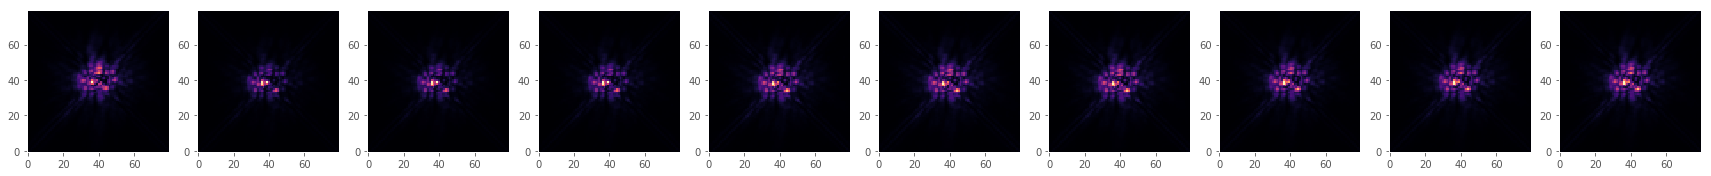

In [6]:
sample_count = 10
sample_start = 100
plt.figure(figsize=(3 * sample_count, 3))
for i in range(1, sample_count + 1):
    plt.subplot(1, 10, i)
    plt.imshow(psf_datacube[sample_start + i])

# Do `scikit-learn` to it

As we have seen, `scikit-learn` has implementations of common data decomposition algorithms—including PCA.

In [7]:
from sklearn import decomposition

We select a number of components to "learn" from the `psf_datacube`:

In [8]:
n_components = 6

In [9]:
pca_fit = decomposition.PCA(n_components=n_components)

Note that the `PCA.fit` method wants a flattened image, as we showed above. Fortunately, NumPy lets us reshape our datacube in place: 

In [10]:
zz, yy, xx = psf_datacube.shape
flattened_psfs = psf_datacube.reshape((zz, yy * xx))
flattened_psfs.shape

(558, 6400)

We can even visualize the set of 558 new $\mathbb{R}^{6400}$ vectors as an image:

In [11]:
vmin, vmax = (np.percentile(flattened_psfs, 5),
              np.percentile(flattened_psfs, 95))

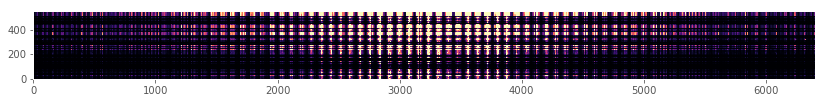

In [12]:
plt.figure(figsize=(14, 4))
plt.imshow(flattened_psfs, vmin=vmin, vmax=vmax)

## Compute the principal components:

In [13]:
pca_fit = pca_fit.fit(flattened_psfs)

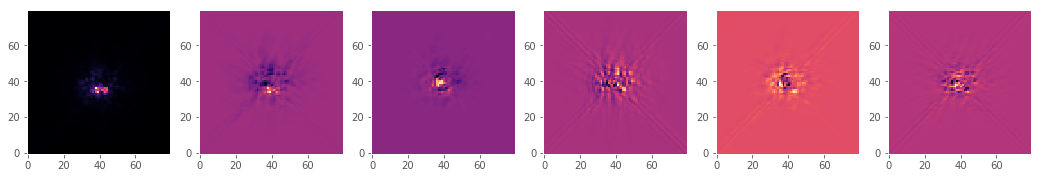

In [14]:
plt.figure(figsize=(3 * n_components, 3))
for i in range(n_components):
    plt.subplot(1, n_components, i + 1)
    plt.imshow(pca_fit.components_[i].reshape(psf_datacube[0].shape))

# Now, to do a PSF subtraction...

Coronagraphers (is that what we call them?) rarely demonstrate their optics or algorithms on "interesting" sources. An image of total starlight suppression would make them very excited, and look like noise to us.

To experience this excitement for ourselves, let us use PCA to model a PSF.

1. Transform the image to the basis defined by the PCA decomposition ($\mathbb{R}^{6400} \rightarrow \mathbb{R}^{6}$)
2. Create a model PSF from the component coefficients and component vectors ($\mathbb{R}^{6} \rightarrow \mathbb{R}^{6400}$)
3. Subtract this model PSF from the original image

In [15]:
# Step 1.
image = psf_datacube[70]
components = pca_fit.transform([image.flatten(),])
# Step 2.
model = pca_fit.inverse_transform(components)
model = model[0].reshape(image.shape)
# Step 3.
difference = image - model

**That's it.**

Aren't free, open-source libraries wonderful? Remember to donate to NumFOCUS and take a deduction on your taxes.

## Visualize the residuals

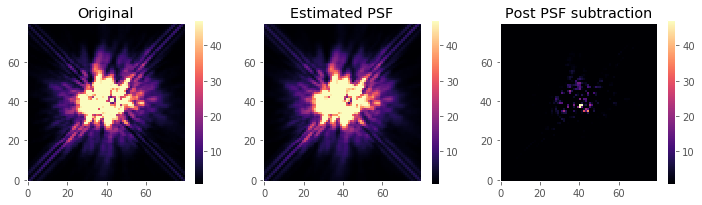

In [16]:
vmin, vmax = np.percentile(image, 5), np.percentile(image, 95)
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.imshow(image, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(model, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated PSF')
plt.subplot(1,3,3)
plt.imshow(difference, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Post PSF subtraction')

As we had hoped, more of the residual starlight is removed, improving our chances of finding planets at smaller separations from the star.

# The Unreasonable Effectiveness of PCA in the Natural Sciences

While preparing this talk, I picked a random plane of the data cube as my "this will show a complete subtraction" example.

To my great surprise, it turned out to show a circumstellar disk.

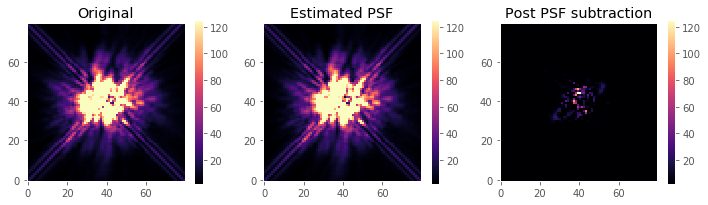

In [17]:
# Step 1.
image = psf_datacube[298]
components = pca_fit.transform([image.flatten(),])
# Step 2.
model = pca_fit.inverse_transform(components)
model = model[0].reshape(image.shape)
# Step 3.
difference = image - model

vmin, vmax = np.percentile(image, 5), np.percentile(image, 95)
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.imshow(image, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(model, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated PSF')
plt.subplot(1,3,3)
plt.imshow(difference, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Post PSF subtraction')

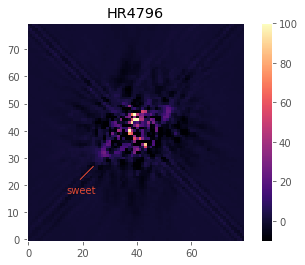

In [18]:
plt.imshow(difference, vmin=-10, vmax=100)
plt.colorbar()
plt.title('HR4796')
plt.arrow(24, 27, -5, -5, color='C0')
plt.text(24-10, 27-10, 'sweet', color='C0')

## pyKLIP overview

KLIP is a (2016) method to achieve point spread function (PSF) subtractions for high-contrast imaging using Principal Component Analysis (PCA) that is applicable to both point sources or extended objects (disks). 

It uses a Karhunen-Loeve (KL) transformation on an existing library of PSF's to obtain an orthogonal basis of eigenimages and projects the science target onto these images.

For detections it uses an algorithm comparable to Locally Optimized Combination of Images (LOCI)

For Characterization of detected sources the method enalbes forward modeling of astrophysical sources (which alleviates the biases in the astrometery and photometry of discovered faint sources)

## Example: Imaging a planet with pyKLIP

We'll be working with the Beta Pictoris system. 
   - Star: debris disk A-type main sequence 
   - One confimed giant planet
      - Mass ~ 7 Jupiter Masses
      - Radius ~ 1.5 Jupiter Radius
      - Orbital Radius ~ 9 AU (1.5x Jupiter's Orbit)
   - Distance ~ 20 pc

Our data was obtained with GPI (Gemini Planet Imager), located on the Gemini South telescope in Cerro Pachón, Chile.
   
Below is an artist's interpretation:

![](https://upload.wikimedia.org/wikipedia/commons/1/12/Artist%E2%80%99s_impression_of_the_planet_Beta_Pictoris_b.jpg)

Let's use pyKLIP to remove the stellar PSF and see what the planet looks like!

*Note: Code below is derived from pyKLIP documentation by Jason Wang and collaborators, used and adapted under the BSD license.*

In [19]:
import pyklip.parallelized as parallelized
import pyklip.instruments.GPI as GPI

## Acquire example files

filelist = glob.glob("pyklip/tests/data/S20131210*distorcorr.fits")
filelist.sort()

print(filelist)

dataset = GPI.GPIData(filelist, highpass=True)

['pyklip/tests/data/S20131210S0092_spdc_distorcorr.fits', 'pyklip/tests/data/S20131210S0099_spdc_distorcorr.fits', 'pyklip/tests/data/S20131210S0111_spdc_distorcorr.fits']
Reading File: pyklip/tests/data/S20131210S0092_spdc_distorcorr.fits
Reading File: pyklip/tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: pyklip/tests/data/S20131210S0111_spdc_distorcorr.fits


In [20]:
## from pyklip.examples.BasicKLIPTutorial 
## do the KLIP algorithm

outputdir = "ryan_example_output_data" # save files here
prefix = "pyklip-betpic-j-131210-k100a9s4m1" # a file prefix to summarize this reduction

parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=prefix,
                          annuli=9, subsections=4, movement=1, numbasis=[1,20,50,100],
                          calibrate_flux=True, mode="ADI+SDI")

Beginning ADI+SDI KLIP
Begin align and scale images for each wavelength
Wavelength 1.11 with index 0 has finished align and scale. Queuing for KLIP
Wavelength 1.133 with index 2 has finished align and scale. Queuing for KLIP
Wavelength 1.128 with index 1 has finished align and scale. Queuing for KLIP
Wavelength 1.139 with index 3 has finished align and scale. Queuing for KLIP
Wavelength 1.145 with index 4 has finished align and scale. Queuing for KLIP
Wavelength 1.157 with index 6 has finished align and scale. Queuing for KLIP
Wavelength 1.151 with index 5 has finished align and scale. Queuing for KLIP
Wavelength 1.163 with index 7 has finished align and scale. Queuing for KLIP
Wavelength 1.169 with index 8 has finished align and scale. Queuing for KLIP
Wavelength 1.174 with index 9 has finished align and scale. Queuing for KLIP
Wavelength 1.181 with index 10 has finished align and scale. Queuing for KLIP
Wavelength 1.187 with index 11 has finished align and scale. Queuing for KLIP
Wav

/Users/jdl/miniconda2/envs/work/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/jdl/miniconda2/envs/work/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [21]:
## Let's see what are results look like 
##showing the continuum for different KL modes:
outputdir = "ryan_example_output_data" # save files here
prefix = "pyklip-betpic-j-131210-k100a9s4m1"

kl_hdulist = fits.open("{out}/{pre}-KLmodes-all.fits".format(out=outputdir, pre=prefix))
klcube = kl_hdulist[1].data
klheader = kl_hdulist[1].header
print("The dimensions of this datacube is {0}".format(klcube.shape))

# reconstruct the KL Mode cutoff axis from the header. 
num_cutoffs = klcube.shape[0] # number of KL mode cutoffs saved
kl_cutoffs = [klheader['KLMODE{0}'.format(cutoff_i)] for cutoff_i in range(num_cutoffs) ] # grab all the KL mode cutoffs from the header

def pltcube(selected_kl_index):
    """
    Function to refresh the plot with the frame from the selected_kl_index
    
    Args:
        selected_wv: the datacube index selected by the widget
    """
    plt.figure(figsize=(8,8))
    plt.imshow(klcube[selected_kl_index], cmap='viridis', vmin=-5e-7, vmax=1e-5)
    plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
    plt.title("{0} KL Modes".format(kl_cutoffs[selected_kl_index]), fontsize=20)
    plt.show()
    
widgets.interact(pltcube, selected_kl_index=(0, num_cutoffs-1, 1))


The dimensions of this datacube is (4, 281, 281)


interactive(children=(IntSlider(value=1, description='selected_kl_index', max=3), Output()), _dom_classes=('widget-interact',))

<function __main__.pltcube>

In [22]:
## to look at one spectral cube

# Read in the data and grab the data from the HDU card in index 1
spec_hdulist = fits.open("{out}/{pre}-KL20-speccube.fits".format(out=outputdir, pre=prefix))
speccube_kl20 = spec_hdulist[1].data
specheader_kl20 = spec_hdulist[1].header
print("The dimensions of this datacube is {0}".format(speccube_kl20.shape))

# reconstruct the wavelength axis from the header. 
# We aren't using dataset.wavelength because to plot the widget plot below, we need a linear wavelenght solution
cube_wvs_step = specheader_kl20['CD3_3'] # \Delta \lambda for each wavelength slice of the cube
cube_wvs_min = specheader_kl20['CRVAL3'] # wavelength of slice 0 of the spectral cube
cube_wvs = cube_wvs_min + np.arange(speccube_kl20.shape[0]) * cube_wvs_step #construct the wavelength axis
cube_wvs_max = cube_wvs[-1] # wavelength of last slice of the spectral cube


def pltcube(selected_wv):
    """
    Function to refresh the plot with the frame from the selected_wv
    
    Args:
        selected_wv: the wavelength selected by the interactive slider bar widget
    """
    wv_index = np.argmin(np.abs(selected_wv - cube_wvs)) # get the index into the array corresponding to the wavelength
    plt.figure(figsize=(8,8)) # create the plot. Make it big
    plt.imshow(speccube_kl20[wv_index], cmap='viridis', vmin=-5e-7, vmax=1e-5) # plot the image
    plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
    plt.title("{0:.3f} microns".format(selected_wv), fontsize=20)
    plt.show()
    
# run the interactive widget
widgets.interact(pltcube, selected_wv=(cube_wvs_min, cube_wvs_max, cube_wvs_step))

The dimensions of this datacube is (37, 281, 281)


interactive(children=(FloatSlider(value=1.2319000363353199, description='selected_wv', max=1.34972707162064, min=1.11407300105, step=0.00654594640474), Output()), _dom_classes=('widget-interact',))

<function __main__.pltcube>

In [23]:
##before and after for different modes

preprocessed_data = fits.getdata('pyklip/tests/data/S20131210S0092_spdc_distorcorr.fits')

start = 0
N_steps = preprocessed_data.shape[0]

def plt_preprocessed_cube(index):
    """
    Function to refresh the plot with the frame from the selected_wv
    
    Args:
        selected_wv: the wavelength selected by the interactive slider bar widget
    """
    plt.figure(figsize=(8,8)) # create the plot. Make it big
    plt.imshow(preprocessed_data[index, :, :], cmap='viridis', vmin =np.nanmin(preprocessed_data),
                                        vmax=np.nanmax(preprocessed_data)) # plot the image
    #plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
    plt.show()


widgets.interact(plt_preprocessed_cube, index=(0, 36, 4))

interactive(children=(IntSlider(value=16, description='index', max=36, step=4), Output()), _dom_classes=('widget-interact',))

<function __main__.plt_preprocessed_cube>

## Using pyKLIP to locate a disk

- The paramaters suggested to locate a disk: 
    - Changing the number of basis vectors `numbasis` (or KLmodes) will show different sets of features. More basis vectors will self-subtract more of the extended PSF structure, where subtracting fewer basis vectors will show more extended features of the disk
    - Suggested to set `annuli=1` since the number of annuli can depend on the geometry of the disk
    - Suggested to set `subsections=1`
    - Only using the `ADI` mode instead of `ADI+SDI`
     

In [28]:

# disk_filelist = glob.glob("sam_disk/HD95086_K1_131210/*distorcorr_*.fits.gz")
# disk_filelist.sort()
# disk_dataset = GPI.GPIData(disk_filelist, highpass=True)
disk_outputdir = "sam_disk" # save files here
disk_prefix = "HD95086" # a file prefix to summarize this reduction

#parallelized.klip_dataset(disk_dataset, outputdir=disk_outputdir, fileprefix=disk_prefix,
#                          annuli=1, subsections=1, movement=1, numbasis=[1,10,40],
#                          calibrate_flux=True, minrot=0, annuli_spacing="log", mode="ADI")

disk_kl_hdulist = fits.open("{out}/{pre}-KLmodes-all.fits".format(out=disk_outputdir, pre=disk_prefix))
disk_klcube = disk_kl_hdulist[1].data
disk_klheader = disk_kl_hdulist[1].header
print("The dimensions of this datacube is {0}".format(disk_klcube.shape))

# reconstruct the KL Mode cutoff axis from the header. 
disk_num_cutoffs = disk_klcube.shape[0] # number of KL mode cutoffs saved
disk_kl_cutoffs = [disk_klheader['KLMODE{0}'.format(cutoff_i)] for cutoff_i in range(disk_num_cutoffs) ] # grab all the KL mode cutoffs from the header

def pltcube(selected_kl_index):
    """
    Function to refresh the plot with the frame from the selected_kl_index
    
    Args:
        selected_wv: the datacube index selected by the widget
    """
    plt.figure(figsize=(8,8))
    plt.imshow(disk_klcube[selected_kl_index], cmap='viridis', vmin=-5e-7, vmax=1e-5)
    plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
    plt.title("{0} KL Modes".format(disk_kl_cutoffs[selected_kl_index]), fontsize=20)
    plt.show()
    
widgets.interact(pltcube, selected_kl_index=(0, disk_num_cutoffs-1, 1))

The dimensions of this datacube is (3, 281, 281)


interactive(children=(IntSlider(value=1, description='selected_kl_index', max=2), Output()), _dom_classes=('widget-interact',))

<function __main__.pltcube>

In [29]:
disk_spec_hdulist = fits.open("{out}/{pre}-KL20-speccube.fits".format(out=disk_outputdir, pre=disk_prefix))
disk_speccube_kl20 = disk_spec_hdulist[1].data
disk_specheader_kl20 = disk_spec_hdulist[1].header
print("The dimensions of this datacube is {0}".format(disk_speccube_kl20.shape))

# reconstruct the wavelength axis from the header. 
# We aren't using dataset.wavelength because to plot the widget plot below, we need a linear wavelenght solution
disk_cube_wvs_step = disk_specheader_kl20['CD3_3'] # \Delta \lambda for each wavelength slice of the cube
disk_cube_wvs_min = disk_specheader_kl20['CRVAL3'] # wavelength of slice 0 of the spectral cube
disk_cube_wvs = disk_cube_wvs_min + np.arange(speccube_kl20.shape[0]) * cube_wvs_step #construct the wavelength axis
disk_cube_wvs_max = disk_cube_wvs[-1] # wavelength of last slice of the spectral cube


def pltcube(selected_wv):
    """
    Function to refresh the plot with the frame from the selected_wv
    
    Args:
        selected_wv: the wavelength selected by the interactive slider bar widget
    """
    wv_index = np.argmin(np.abs(selected_wv - cube_wvs)) # get the index into the array corresponding to the wavelength
    plt.figure(figsize=(8,8)) # create the plot. Make it big
    plt.imshow(speccube_kl20[wv_index], cmap='viridis', vmin=-5e-7, vmax=1e-5) # plot the image
    plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
    plt.title("{0:.3f} microns".format(selected_wv), fontsize=20)
    plt.show()
    
# run the interactive widget
widgets.interact(pltcube, selected_wv=(disk_cube_wvs_min, disk_cube_wvs_max, disk_cube_wvs_step))

The dimensions of this datacube is (37, 281, 281)


interactive(children=(FloatSlider(value=1.99768109739976, description='selected_wv', max=2.12174601651064, min=1.88609194594, step=0.00858378088152), Output()), _dom_classes=('widget-interact',))

<function __main__.pltcube>

## The Performance of Other Algorithms: LOCI, NMF, ICA

We have discussed how to perform PSF modeling and subtraction using PCA (aka KLIP), ICA and NMF. 

Another algorithm, named Localized Optimized Combination of Images (LOCI, see Lafreniere et al. 2007) has also been frequently used in high-contrast imaging.

How do these algorithms work? Which one should I use?

### Localized Optimized Combination of Images (LOCI)

In LOCI, we start from a library of PSF stars and the image of the object to be analyzed.

> The heart of the algorithm described here is
to divide the target image into subsections and to obtain, 
independently for each subsection, a linear combination of the reference
images whose subtraction from the target image will minimize the
noise."

— Lafreniere et al. 2007

But wait...

"a linear combination of the reference images"...

... LOCI is equivalent to PCA which uses all the components (Males 2017, in prep).

You can also perform PCA on a bunch of sunsections (which is actually done in the previous examples)

### A Quick Look at the Output of ICA and NMF

We will need SWarp (https://www.astromatic.net/software/swarp) in the data reduction. The installation is a bit annoying... You can skip the next several cells if you want (the output images are directly available in the data directory).

Data: The Integrate Field Spectroscopy of $\beta$ Pic taken by Gemini Planet Imager (GPI). 19 individual images.

Method: Use the images of the object themselves to generate a set of components, using PCA, ICA and NMF.

In [38]:
### Read the data ###

import os
import numpy as np
from scipy.optimize import minimize
from astropy.io import fits
import matplotlib.pyplot as plt
import glob
import pyklip.instruments.GPI as GPI

from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

cwd=os.getcwd()
data_dir=cwd+'/betaPic_J_131210'

filelist = glob.glob(data_dir+"/*.fits.gz")
dataset = GPI.GPIData(filelist, highpass=True)

### Select images at a certain wavelength
imagecube = dataset.input[1::37]
filenamelist = dataset.filenames[1::37]

Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0092_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0093_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0094_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0095_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0096_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0097_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0098_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0099_spdc_distorcorr.fits.gz
Reading File: /Volumes/Gewgaws/Ast-502-final-project/betaPic_J_131210/S20131210S0100_spdc_distorcorr.fits.gz
Reading File: /Volu

In [40]:
def fit_image_method(datacube, method='pca', n_images_to_use=-1, n_components=10, show_components=False,\
                    show_number=3):
    '''
    Fit the input set of image with PCA, ICA of NMF
    '''
    ### Preparing the data ###
    
    print('Begin fitting using '+method.upper())
    print('Number of components to fit: '+str(n_components))
    
    imagelist=[]
    size=datacube[0].size
    shape=datacube[0].shape
    
    datacube_tmp=datacube.copy()
    
    datacube_tmp[np.isnan(datacube_tmp)]=0
    datacube_tmp[np.isinf(datacube_tmp)]=0

    if method=='nmf':
        datacube_tmp[datacube_tmp<0]=0
    elif method in ['pca','ica']:
        n_components-=1
        
    for index in range(len(datacube)):
        weight=np.sum(datacube_tmp[index])
        imagelist.append(datacube_tmp[index].reshape(size))
    
    imagelist=np.array(imagelist)
    
    ica = FastICA(n_components=n_components)
    pca=PCA(n_components=n_components)
    nmf=NMF(n_components=n_components)

    fitmodel_dict={'pca':pca,\
                     'ica':ica,\
                     'nmf':nmf}
    
    fitmodel=fitmodel_dict[method]
    
    if n_images_to_use<0:
        n_images_to_use=len(imagelist)
        
    fitmodel.fit(imagelist[:n_images_to_use])
    residual_list=[]
    
    for raw_index in range(len(imagelist)):

        raw_row=imagelist[raw_index]
        raw_image=raw_row.reshape(shape)

        coeffs=fitmodel.transform([raw_row])
        fitdata_reconstruct=fitmodel.inverse_transform(coeffs)
        fitdata_reconstruct=fitdata_reconstruct.reshape(shape)
        
        residual_list.append(raw_image-fitdata_reconstruct)
        
    if show_components:
            
        if show_number>n_components:
            show_number=n_components
        components=fitmodel.components_
        min_percentile, max_percentile = 20, 100
        vmin=np.percentile(components[0], min_percentile)
        vmax=np.percentile(components[0], max_percentile)*0.1
        
        # Plot the results
        fig = plt.figure(figsize=(10, 3))
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                            bottom=0.1, top=0.95, hspace=0.05)

        for j in range(show_number):
            ax = fig.add_subplot(1, show_number, j+1)
            ax.imshow(components[j].reshape(shape),vmin=vmin,vmax=vmax,origin='lower')
            ax.set_title('Component '+str(j), fontsize=16)

        plt.show(fig)
    
    
    return residual_list



def coadd_images(data_list,filename_list,output,show_result=True,title=''):
    
    ### Coadd the PSF-subtracted images ###
    
    filenamelist=[]
    
    for index in range(len(data_list)):
        fitsdata=fits.open(filename_list[index])
        fitsdata[1].data=data_list[index]
        
        if os.path.exists(data_dir+'/save/tmp'+str(index)+'.fits'):
            os.system('rm '+data_dir+'/save/tmp'+str(index)+'.fits')
        fitsdata.writeto(data_dir+'/save/tmp'+str(index)+'.fits')
        filenamelist.append(data_dir+'/save/tmp'+str(index)+'.fits')
        
    np.savetxt('swarp_input',filenamelist,fmt='%s')
    os.system('swarp @swarp_input -IMAGEOUT_NAME '+output)
    
    data=fits.open(output)[0].data
    
    if show_result:
        min_percentile, max_percentile = 20, 100
        vmin=np.percentile(data, min_percentile)
        vmax=np.percentile(data, max_percentile)*0.1
        
        fig = plt.figure(figsize=(5, 5))
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                            bottom=0.1, top=0.95, hspace=0.05)
        
        ax=fig.add_subplot(111)
        ax.imshow(data,vmin=vmin,vmax=vmax,origin='lower')
        ax.set_title(title, fontsize=16)

        plt.show(fig)
        
    return data

Begin fitting using PCA
Number of components to fit: 10


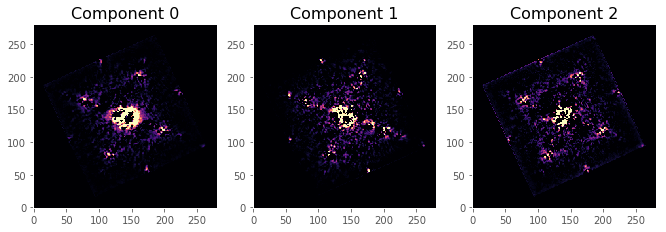

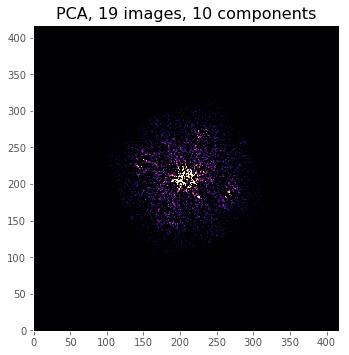

Begin fitting using ICA
Number of components to fit: 10


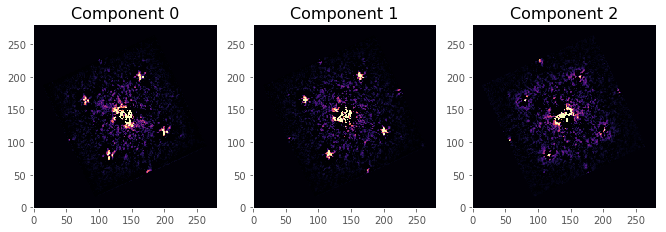

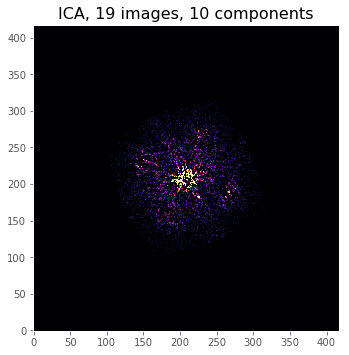

Begin fitting using NMF
Number of components to fit: 10


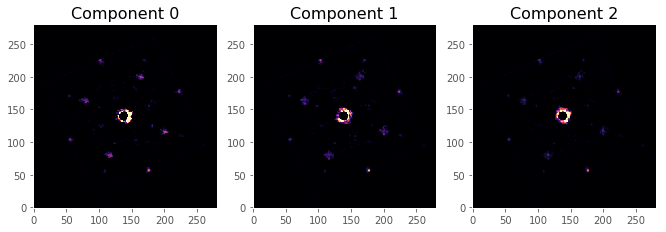

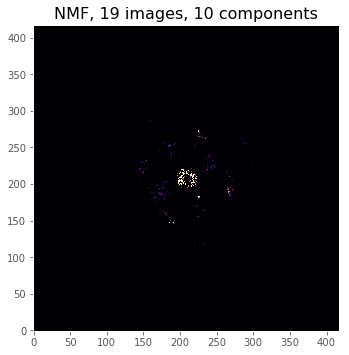

In [41]:
n_images_to_coadd=19
n_components=10
n_images_to_use=19

images_to_run=imagecube[:n_images_to_coadd]
filename_to_run=list(filenamelist[:n_images_to_coadd])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method,\
                             n_components=n_components, show_components=True)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')
    



We will discuss of the influence of
- The number of images to calculate the components
- The signal-to-noise ratio of the images

Begin fitting using PCA
Number of components to fit: 2


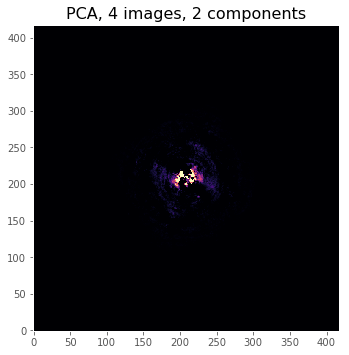

Begin fitting using ICA
Number of components to fit: 2


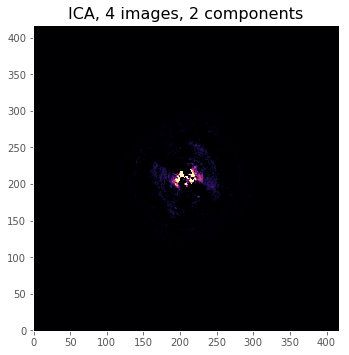

Begin fitting using NMF
Number of components to fit: 2


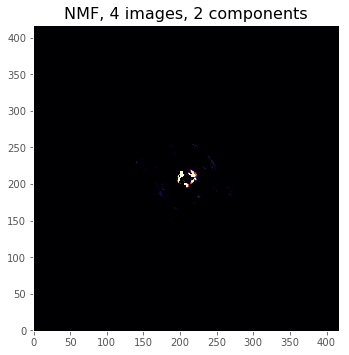

In [42]:
### Check the influence of the number of images used to generate the components ###

n_images_to_coadd=19
n_components=2
n_images_to_use=4

images_to_run=imagecube[:n_images_to_coadd]
filename_to_run=list(filenamelist[:n_images_to_coadd])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method, n_images_to_use=n_images_to_use,\
                             n_components=n_components)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')

Begin fitting using PCA
Number of components to fit: 10


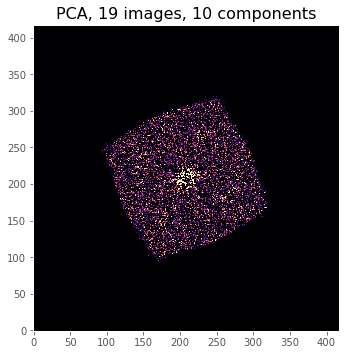

Begin fitting using ICA
Number of components to fit: 10


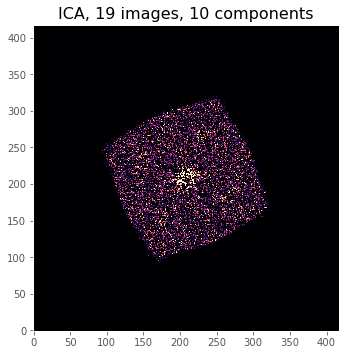

Begin fitting using NMF
Number of components to fit: 10


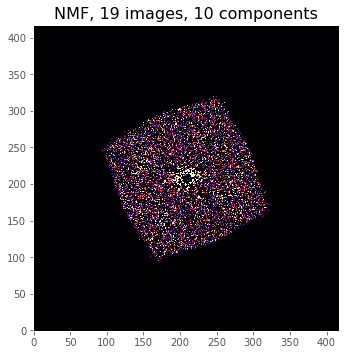

In [43]:
### Check the influence of the Signal - to - Noise Ratio ###

n_images_to_coadd=19
n_components=10
n_images_to_use=19

noise_level=2500 ### This makes the planet a ~5sigma detection after coaddition
noise_matrix=np.random.poisson(noise_level, imagecube.shape)
imagecube_noisy=imagecube+noise_matrix


images_to_run=imagecube_noisy[:n_images_to_coadd]
filename_to_run=list(filenamelist[:n_images_to_coadd])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method, n_images_to_use=n_images_to_use,\
                             n_components=n_components)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')

Begin fitting using PCA
Number of components to fit: 2


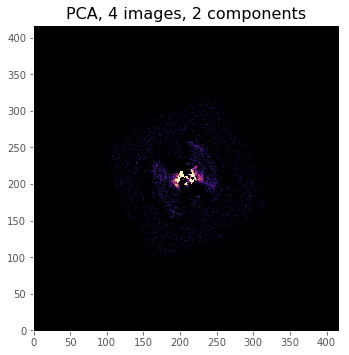

Begin fitting using ICA
Number of components to fit: 2


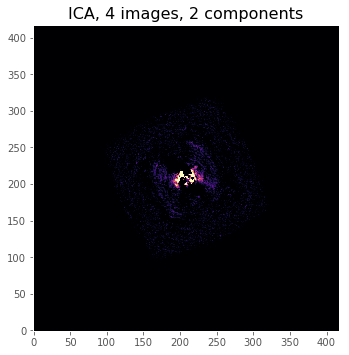

Begin fitting using NMF
Number of components to fit: 2


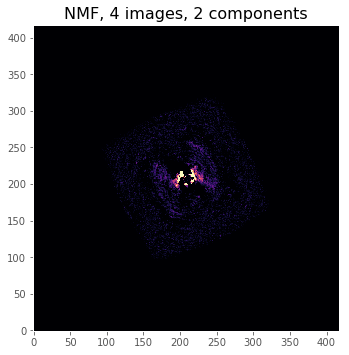

In [44]:
### Let's try the worst case! ###

n_images_to_coadd=19
n_components=2
n_images_to_use=4

noise_level=2500 ### This makes the planet a ~5sigma detection after coaddition
noise_matrix=np.random.poisson(noise_level, imagecube.shape)
imagecube_noisy=imagecube+noise_matrix


images_to_run=imagecube_noisy[:n_images_to_coadd]
filename_to_run=list(filenamelist[:n_images_to_coadd])

for method in ['pca','ica','nmf']:
    subtract=fit_image_method(images_to_run,method=method, n_images_to_use=n_images_to_use,\
                             n_components=n_components)
    
    coadd_images(subtract, filename_to_run, show_result=True, \
                 title=method.upper()+', '+str(n_images_to_use)+' images, '+str(n_components)+' components',\
                 output=data_dir+'/save/'+method+'_'+str(n_images_to_use)+'_'+str(n_components)+'.fits')

### Discussions about ICA and NMF

ICA

- Though the components of ICA is different from PCA, the reconsructed PSF is almost the same as PCA.
- How can we intepret the ICA components? I don't know...

NMF
- NMF seems to work better for higher SNR images
- The PSF can be regarded as an assembly of several parts (e.g., the core and the wings). Probably that is why NMF works well.

PCA
- Straightforward, fast!

## Summary

- LOCI is a special case of PCA
- PCA, ICA and NMF all work well in PSF modeling
- The performance of ICA and PCA is nearly identical
- With only a few images to compute the components, the residual will be larger, but is also good enough for detecting a planet.
- When you have high SNR images, maybe NMF is a better choice?



## Conclusions
- PCA is a widely used dimensionality reduction technique 
- Exoplanet researchers often use PCA to remove the stellar PSF from coronagraphic images, which allows for direct imaging of exoplanets and debris disks
- Achieving higher contrast requires a combination of hardware and software advances